In [112]:
from google.colab import files
import pandas as pd
import requests
from bs4 import BeautifulSoup
import csv
import html5lib
import time
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

#Read in all NHL transactions and filter for trades only
df=pd.read_csv("Hockey_trades_final.csv")

In [113]:
#Current NHL teams
teams = {"Ducks":{},
"Coyotes":{},
"Bruins":{},
"Sabres":{},
"Flames":{},
"Hurricanes":{},
"Blackhawks":{},
"Avalanche":{},
"BlueJackets":{},
"Stars":{},
"RedWings":{},
"Oilers":{},
"Panthers":{},
"Kings":{},
"Wild":{},
"Canadiens":{},
"Predators":{},
"Devils":{},
"Islanders":{},
"Rangers":{},
"Senators":{},
"Flyers":{},
"Penguins":{},
"Sharks":{},
"Blues":{},
"Lightning":{},
"MapleLeafs":{},
"Canucks":{},
"GoldenKnights":{},
"Capitals":{},
"Jets":{},
                }

In [115]:
df=df.drop(columns = 'Unnamed: 0')
df.head()

,Team A,Asset Sent,Asset Received,Team B,Num Players Sent,Num Player Received,Year,Month,Day
0,Canadiens,• cash,• Tommy Smith,Senators,1,1,1918,11,28
1,Senators,• Tommy Smith,• cash,Canadiens,1,1,1918,11,28
2,Bruins,• Lionel Hitchman,• cash,Senators,1,1,1925,1,10
3,Senators,• cash,• Lionel Hitchman,Bruins,1,1,1925,1,10
4,Bruins,• Sprague Cleghorn,• $5K cash,Canadiens,1,1,1925,11,8


In [ ]:
#TODO
#Fix space formating in column 4 xxxx
#Fix data for teams that have moved or changed names xxx
#Split the date columns xxxx
#Variable for players sent/received xxxx

In [118]:
#Build nested dictionary of teams and their trade partners

for index, row in df.iterrows():
    a = row["Team A"]
    for team in teams.keys():
      if team in row["Team B"]:
        b=team
        
        if a not in teams.keys():
          continue

        if b not in teams[a].keys():
          teams[a][b] = 1
        else:
          teams[a][b] += 1

#For some reason the csv indicated that a team had traded with itself. Remove these
for team in teams:
  if team in teams[team].keys():
    teams[team].pop(team, None)



In [119]:
#Construct the graph
#Edge weights correspond to number of transactions
G = nx.Graph()

for team in teams:
  G.add_node(team)

for team_A in teams:
  for team_B in teams[team_A]:
    G.add_edge(team_A, team_B, weight=teams[team_A][team_B])


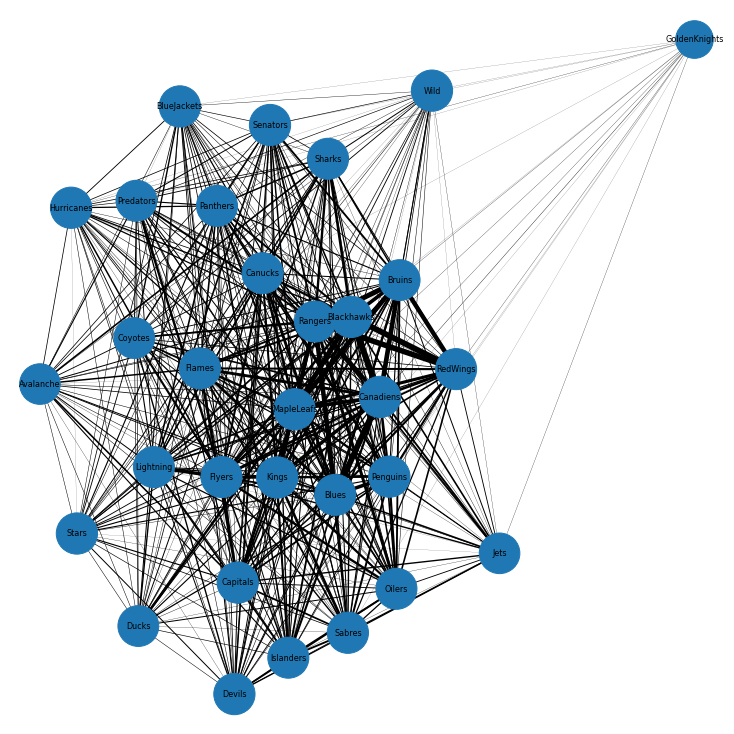

In [120]:
plt.figure(figsize=(10,10))

d = dict(G.degree)
weights = nx.get_edge_attributes(G,'weight').values()


#nx.draw_networkx_edge_labels(G, pos=nx.spring_layout(G))
nx.draw(G, nodelist=d.keys(), width=[weight/8 for weight in weights], node_size=[np.log(v) * 500 for v in d.values()], with_labels=True, pos=nx.spring_layout(G),font_color='k',font_size=8)
plt.show()

In [121]:
nx.average_shortest_path_length(G)

1.0408602150537634

In [158]:
page_rank_dict = nx.pagerank(G)
bt_dict = nx.betweenness_centrality(G)

In [124]:
cups_df=pd.read_csv("stanley_cup_data.csv")

In [125]:
cups_df.tail()

,Team,Wins,Losses,Win %,Division,Joined League,All GP,All W,All L,All T,All OTL,All Points,All PTS%,Cup Apps,Cup App Seasons
26,Predators,0,1,0.000,Central,1998,"1,675",821,633,60,161,"1,863",0.556,1,2017
27,Bruins,6,14,0.300,East,1924,"6,570","3,208","2,387",791,184,"7,391",0.562,20,"1927, 1929, 1930, 1939, 1941, 1943, 1946, 1953..."
28,Flyers,2,6,0.250,East,1967,"4,115","2,054","1,429",457,175,"4,740",0.576,8,"1974, 1975, 1976, 1980, 1985, 1987, 1997, 2010"
29,Canadiens,24,9[a],0.727,North,1917,"6,731","3,449","2,281",837,164,"7,899",0.587,34,"1916, 1917, 1919[a], 1924, 1925, 1930, 1931, 1..."
30,GoldenKnights,0,1,0.000,West,2017,235,133,80,0,22,288,0.613,1,2018


In [141]:
for index, row in cups_df.iterrows():
  team = row['Team']
  teams[team]['cup_appearances'] = row['Cup Apps']
  teams[team]['cup_wins'] = row['Wins']
  teams[team]['cup_losses'] = row['Losses']
  teams[team]['cup_win_pct'] = row['Win %']
  teams[team]['Division'] = row['Division']
  teams[team]['All PTS%'] = row['All PTS%']



In [160]:
page_rank_list=[value for value in page_rank_dict.values()]
bt_list=[value for value in bt_dict.values()]
all_pts_pct_list = []
cup_win_pct_list = []
for key in page_rank_dict:
  all_pts_pct_list.append(teams[key]["All PTS%"])
for key in page_rank_dict:
  cup_win_pct_list.append(teams[key]["cup_win_pct"])  

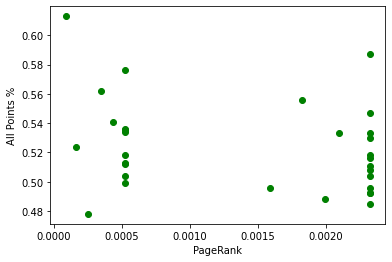

In [167]:
plt.xlabel("PageRank")
plt.ylabel("All Points %")
#plt.scatter(x=page_rank_list, y=all_pts_pct_list, color='red')
#plt.scatter(x=page_rank_list, y=cup_win_pct_list, color='blue')
plt.scatter(x=bt_list, y=all_pts_pct_list, color='green')
#plt.scatter(x=bt_list, y=cup_win_pct_list, color='pink')

In [168]:
from scipy.stats import pearsonr
corr, _ = pearsonr(all_pts_pct_list,cup_win_pct_list)
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: -0.069
